# **Riview Study**

## Objectives
* Evaluate missing data
* Clean data

## Inputs
* General Dataset: outputs/datasets/collection/BreakfastSurvey.csv

## Outputs
* Generate cleaned train and test sets, both under outputs/datasets/cleaned

---

## Change working directory
We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

---

## Load Data

In [5]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/BreakfastSurvey.csv")
df.head(3)

,appearance,breakfast,service,staff,variety,price,taste
0,2,No,4,2,2,4,4
1,3,No,4,2,4,4,4
2,1,No,4,2,1,2,2


## PPS Analysis

In [6]:
import ppscore as pps

pps_matrix = pps.matrix(df).pivot(columns='x', index='y', values='ppscore')
pps_matrix = pps_matrix.round(2)
pps_matrix

x,appearance,breakfast,price,service,staff,taste,variety
y,,,,,,,
appearance,1.00,0.00,0.77,0.00,0.00,0.75,0.55
breakfast,0.00,1.00,0.00,0.33,0.37,0.00,0.00
price,0.62,0.02,1.00,0.01,0.04,0.92,0.52
service,0.00,0.00,0.00,1.00,0.00,0.00,0.00
staff,0.00,0.02,0.00,0.00,1.00,0.00,0.00
taste,0.60,0.02,0.92,0.01,0.03,1.00,0.54
variety,0.57,0.00,0.57,0.00,0.00,0.58,1.00


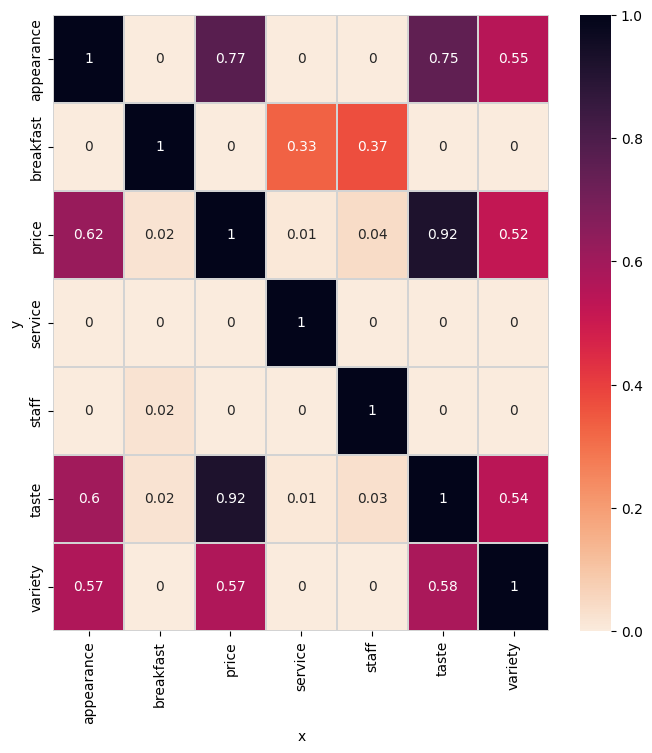

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(8,8))

ax = sns.heatmap(pps_matrix, annot=True,
                       cmap='rocket_r', linewidth=0.05,
                       linecolor='lightgrey')

plt.ylim(len(pps_matrix.columns),0)
plt.show()


In [15]:
len(pps_matrix.columns)

7

In [ ]:
import numpy as np

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                )
    axes.set_yticklabels(df.columns, rotation=0)
    plt.ylim(len(df.columns), 0)
    plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    mask = np.zeros_like(df, dtype=bool)
    mask[abs(df) < threshold] = True
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                     mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                     linewidth=0.05, linecolor='grey')
    plt.ylim(len(df.columns), 0)
    plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("Spearman Correlation")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("Pearson Correlation")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("Power Predictive Score")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [10]:


df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)



PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%    50%    75%    max
ppscore   42.0  0.209  0.307  0.0  0.0  0.006  0.532  0.921




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



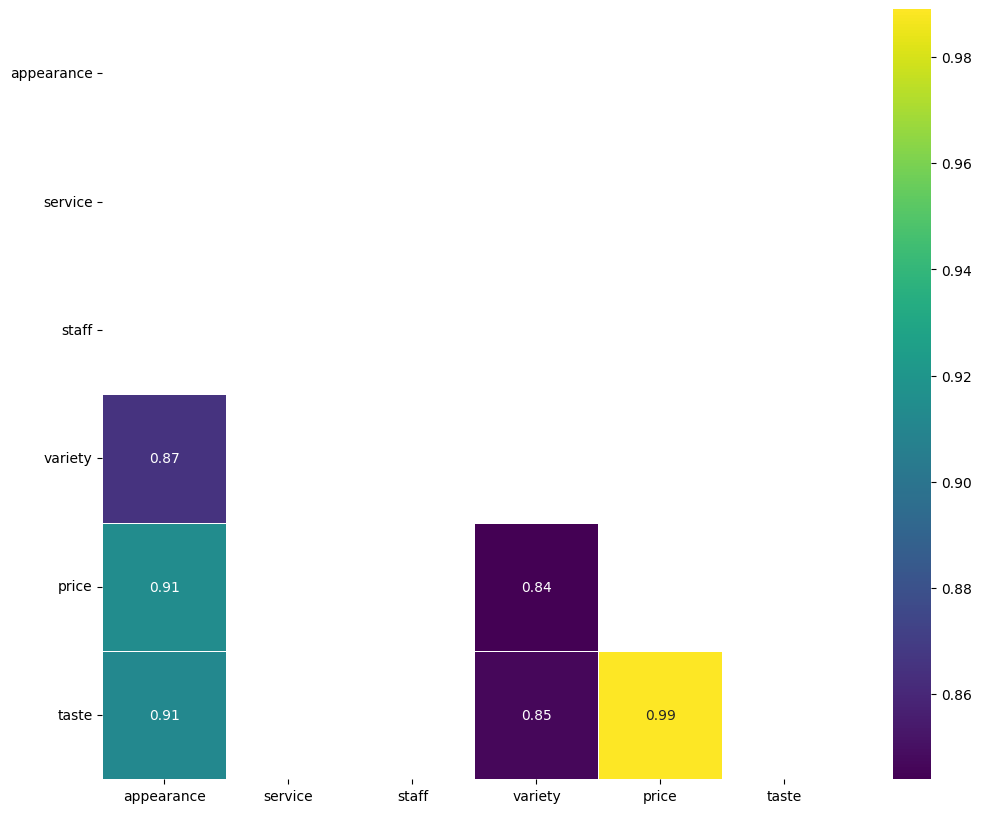



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



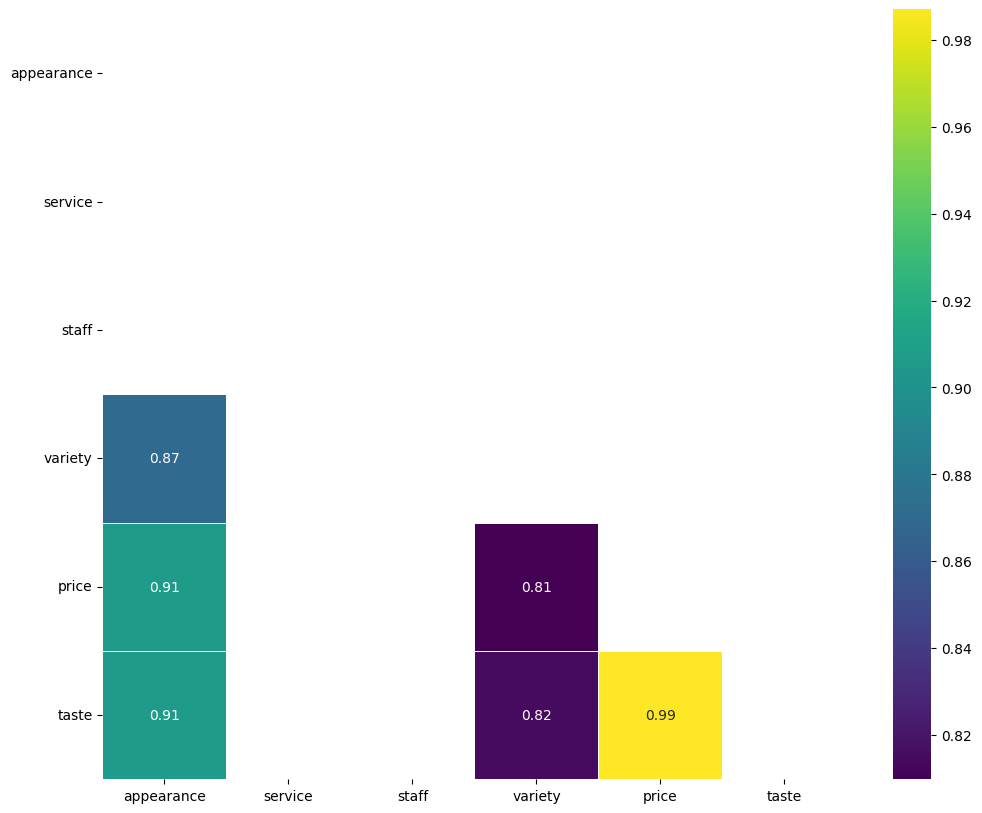



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



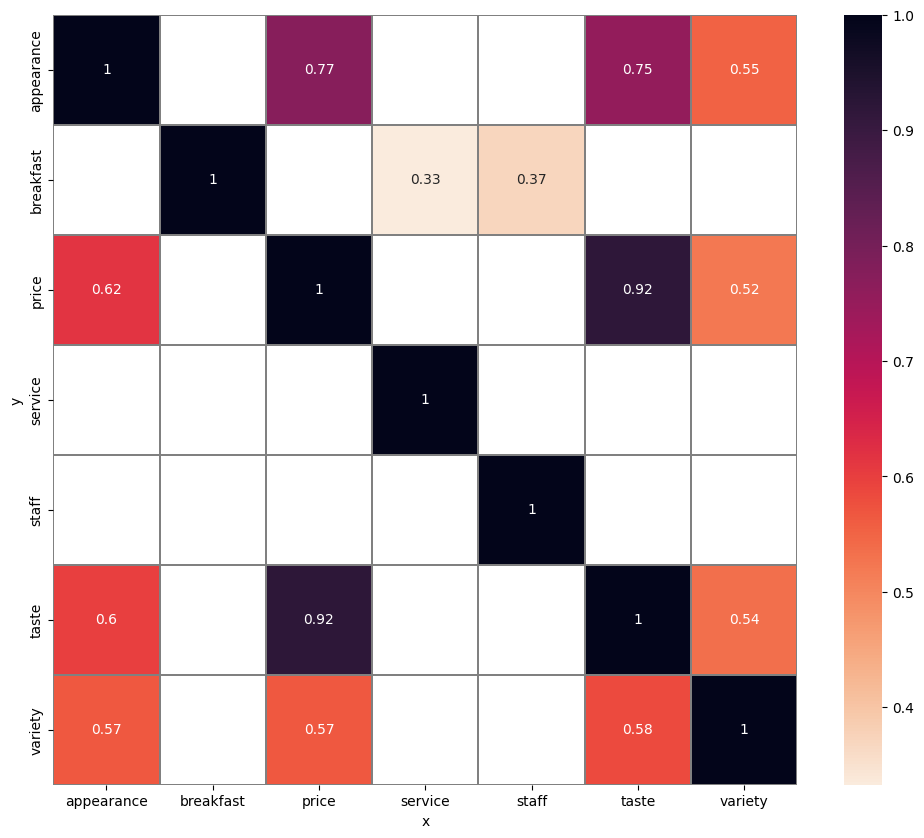

In [18]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

## Split and save train and test set

Create train and test set

In [19]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['breakfast'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (22357, 7) 
TestSet shape: (5590, 7)


Create folder for the train and test set

In [20]:


import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)



Save train set

In [21]:

TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

Save test set

In [22]:

TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)